# Imports

In [1]:
import pandas as pd
import numpy as np
import random 

# Graphing.
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Text Processing.
import nltk
from nltk.corpus import stopwords
import unicodedata
import re
import spacy

# Paths

In [2]:
data_path = './data/'

data_name = 'dataset.csv'

# Load

In [3]:
data = pd.read_csv(data_path + data_name, low_memory=False)
print(data.shape)
data.head()

(1435, 9)


,id_categoria,id_catalogo,id_publicacion,id_comentario,marca,rate,valorization,title,content
0,e45af82f,d7d17801,438bbf39,419611d7,A,5,2,Excelente,Lamparas para un bote de 8 centímetros de diám...
1,e45af82f,d7d17801,438bbf39,23e52627,A,3,0,Bueno,"Tengo 10 lámparas de estas, en menos de 2 años..."
2,e45af82f,80f01ab6,3e7e9ca6,20c689b0,A,5,0,Excelente,Excelente compra muy bonitas.
3,e45af82f,80f01ab6,3e7e9ca6,839dca70,A,5,0,Excelente,Hermosas.
4,e45af82f,80f01ab6,3e7e9ca6,378878a3,A,5,0,Excelente,Muy bonita mejor se lo que se ve el la foto.


In [4]:
data.describe()

,rate,valorization
count,1435.000000,1435.000000
mean,4.563763,0.262718
std,1.008650,1.265891
min,1.000000,-2.000000
25%,5.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,22.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_categoria    1435 non-null   object
 1   id_catalogo     1435 non-null   object
 2   id_publicacion  1435 non-null   object
 3   id_comentario   1435 non-null   object
 4   marca           1435 non-null   object
 5   rate            1435 non-null   int64 
 6   valorization    1435 non-null   int64 
 7   title           1435 non-null   object
 8   content         1419 non-null   object
dtypes: int64(2), object(7)
memory usage: 101.0+ KB


In [6]:
# Observare nulos primero.
data.isnull().sum()

id_categoria       0
id_catalogo        0
id_publicacion     0
id_comentario      0
marca              0
rate               0
valorization       0
title              0
content           16
dtype: int64

---

# EDA

In [7]:
def plot_hist(data, column, is_variable_str=False):
    '''Funtion to plot column distribution'''
    if is_variable_str:
        data[column].value_counts().plot(kind='bar')
    else:
        data[column].hist()
    plt.title(column)
    plt.show()

## Exploracion de variables.

Hay 16 registros que tienen la variable 'content' nula, por lo tanto deberemos evaluar si eliminar estos registros ya que no cuentan con informacion para analizar.

In [8]:
# Cuantas categorias tenemos.
categorias = data['id_categoria'].nunique()
print(f'Cantidad de categorias: {categorias}')

Cantidad de categorias: 32


In [9]:
# Cuantos catalogos.
catalogos = data['id_catalogo'].nunique()
print(f'Cantidad de catalogos: {catalogos}')

Cantidad de catalogos: 213


In [10]:
# Cuantas publicaciones hay.
publicaciones = data['id_publicacion'].nunique()
print(f'Cantidad de publicaciones: {publicaciones}')

Cantidad de publicaciones: 353


In [11]:
# Cantidad de comentarios. -> deberia corresponderse con la cantidad de registros
comentarios = data['id_comentario'].nunique()
print(f'Cantidad de comentarios: {comentarios}')

if comentarios == data.shape[0]:
    print('La cantidad de comentarios es igual a la cantidad de registros.')
else:
    print('Podria haber comentarios repetidos.')

Cantidad de comentarios: 1435
La cantidad de comentarios es igual a la cantidad de registros.


Tener en cuenta que tenemos 16 registros sin comentarios.

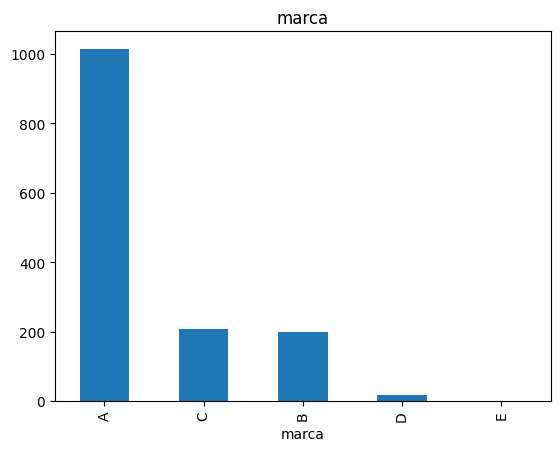

In [12]:
# Observo distintas marcas del producto puiblicado.
plot_hist(data,'marca', is_variable_str=True)

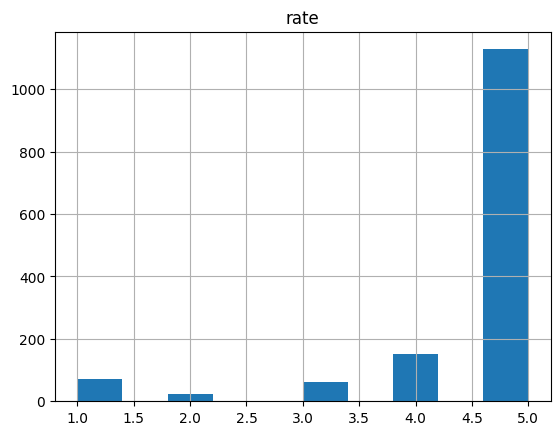

In [13]:
plot_hist(data,'rate', is_variable_str=False)

La mayoria de los productos tienen reviews positivas.

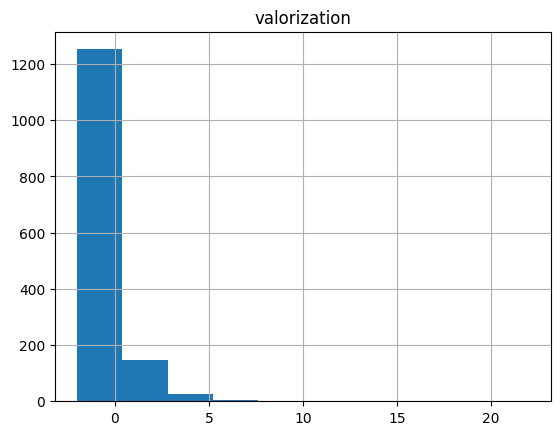

In [14]:
# Vamos a observar la distribucion de la valorizacion.
plot_hist(data,'valorization', is_variable_str=False)

<Axes: xlabel='rate', ylabel='mean_valorization'>

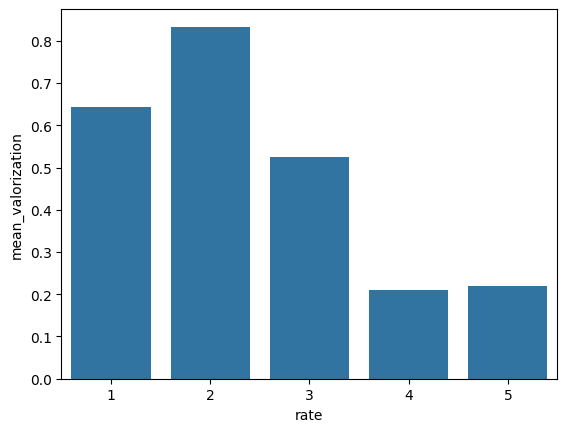

In [15]:
# Vamos a ver la valorizacion promedio por rate.
df_plot = data.groupby('rate')['valorization'].mean().reset_index(name='mean_valorization')
sns.barplot(x='rate', y='mean_valorization', data=df_plot)

La valorizacion pareciera tener valores negativos, y ademas la mayoria de las valorizaciones son nulas.

Habria que evaluar en mas detalle esta variable para ver si influye significativamente.

A primera vista, la utilidad de esta variable podria ser validar, o no, un comentario en X publicacion.

- Idea 1: Incluir la variable 'valorization' como variable mas en el modelo, esto nos ayudaria a reforzar un comentario o no (si tuviera valorizacion negativa).

- Idea 2: Esta variable tambien podria servir para la creacion del target, por ejemplo, un rate de 4 con valoraciones negativas podria ser categorizado como un comentario neutro.

Nota: Como la mayoria de las valoraciones son nulas, creo que es mejor dejarla como feature auxiliar, no como base del target.


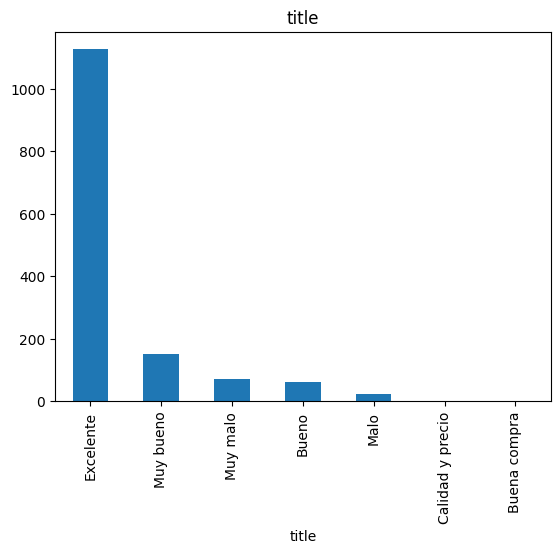

In [16]:
# Vamos a observar la distribucion del titulo.
plot_hist(data,'title', is_variable_str=True)

In [17]:
# Voy a observar si el titulo se condice con el rate.
# Asi tambien de esa manera podre estudiar como se comporta el rate en funcion del titulo, para comenzar a crear el target.
data.groupby(['rate'])['title'].unique()

rate
1                                     [Muy malo]
2                                         [Malo]
3                                        [Bueno]
4                                    [Muy bueno]
5    [Excelente, Calidad y precio, Buena compra]
Name: title, dtype: object

Observando esto vemos que el rate y el titulo estan altamente correlacionados, esto con podria utilizarse para la creacion del target.

---

## Validacion de variables.

Aqui realizaremos algunas validaciones para corroborar que lo que se dice en el enunciado efectivamente se esta cumpliendo.

Y para analizar la relacion entre variables.

In [18]:
# Veo si una marca se corresponde a cada publicacion.
data.groupby(['id_publicacion'])['marca'].nunique().value_counts()

marca
1    353
Name: count, dtype: int64

Aqui estamos validando que a cada publicacion se corresponda un UNICO producto.

In [19]:
# Observo si una publicacion pertenece a una sola categoria.
data.groupby(['id_publicacion'])['id_categoria'].nunique().value_counts()

id_categoria
1    353
Name: count, dtype: int64

Una publicacion pertenece a una unica categoria.

In [20]:
# Una publicacion pertenece a un catalogo.
data.groupby(['id_publicacion'])['id_catalogo'].nunique().value_counts()

id_catalogo
1    353
Name: count, dtype: int64

Una publicacion pertenece a una unico catalogo.

---

## Analisis Exploratorio

### Rate promedio por marca

<Axes: xlabel='marca', ylabel='rate'>

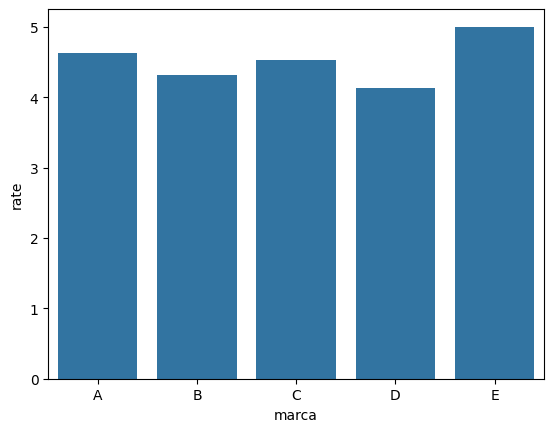

In [21]:
df_plot = data[['marca', 'rate']].groupby('marca').mean().reset_index()
sns.barplot(x='marca', y='rate', data=df_plot)

- La marca 'E' tiene el mayor promedio.
- El promedio de rates entre las distintas marcas es bastante similar.

### Cantidad de comentarios por marca.

<Axes: xlabel='marca', ylabel='count'>

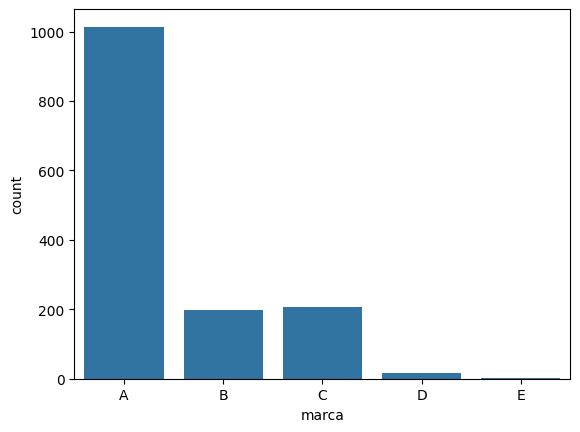

In [22]:
df_plot = data[['marca', 'id_comentario']].groupby('marca').size().reset_index(name='count')
sns.barplot(x='marca', y='count', data=df_plot)

- La marca con mayor cantidad de comentarios es la marca A.
- La marca E es la de menor cantidad de comentarios y solo tiene un unico comentario.

### Publicaciones por marca

<Axes: xlabel='marca', ylabel='count'>

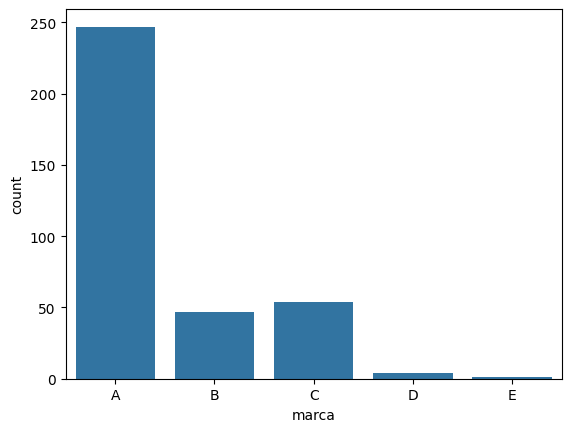

In [23]:
df_plot = data[['marca', 'id_publicacion']].groupby('marca')['id_publicacion'].nunique().reset_index(name='count')
sns.barplot(x='marca', y='count', data=df_plot)

- La marca 'A' es la que mayor cantidad de publicaciones tiene.
- La marca 'E' es la que menor cantidad de publicaciones tiene, una unica, esa unica publicacion se corresponde con el unico comentario en esa marca.

### Cantidad de Catalogos por Marca

<Axes: xlabel='marca', ylabel='count'>

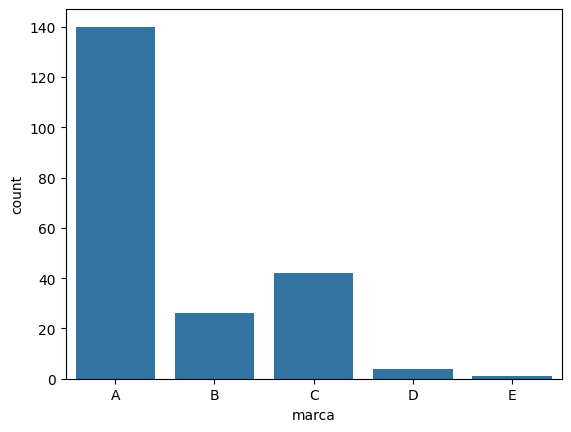

In [24]:
df_plot = data[['marca','id_catalogo']].groupby('marca')['id_catalogo'].nunique().reset_index(name='count')
sns.barplot(x='marca', y='count', data=df_plot)

- La marca 'A' aparece en la mayoria de los catalogos.

### Categorias por Marca

<Axes: xlabel='marca', ylabel='count'>

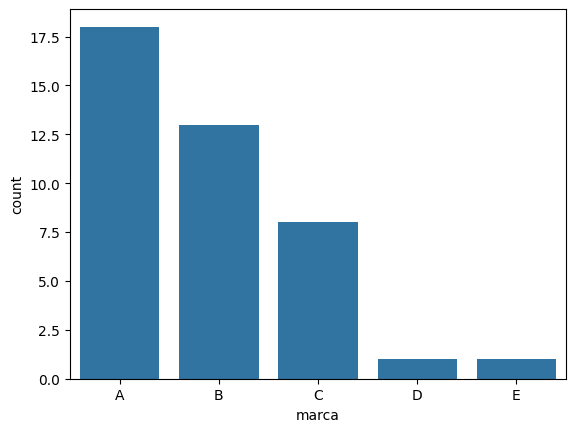

In [25]:
df_plot = data[['marca','id_categoria']].groupby('marca')['id_categoria'].nunique().reset_index(name='count')
sns.barplot(x='marca', y='count', data=df_plot)

- Aqui se observa que la Marca 'B' Aparece en mayor cantidad de categorias que la marca 'C', pero aunque aparezca en mayor cantidad de categorias, puede pasar que un catalogo tenga varias publicaciones de una misma marca, por esa razon la marca 'C' tiene mayor cantidad de comentarios que la marca 'B'

<Axes: xlabel='id_catalogo', ylabel='count'>

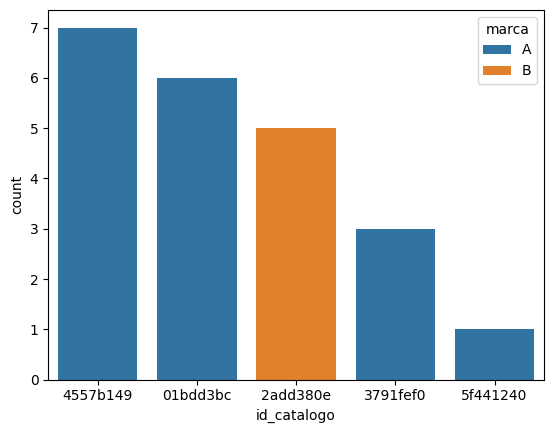

In [26]:
# Puede pasar que un catalogo tenga varias publicaciones de un mismo producto?
df_plot = data[['id_catalogo', 'id_publicacion', 'marca']].drop_duplicates()
df_plot = df_plot.groupby(['id_catalogo', 'marca']).size().reset_index(name='count').sort_values('count', ascending=False)

# Voy a seleccionar los 5 catalogos con mayor cantidad de publicaciones.
id_max_publicaciones = data.groupby(['id_catalogo'])['id_publicacion'].count().sort_values(ascending=False).index
id_max_publicaciones = id_max_publicaciones[0:5].tolist()

df_plot = df_plot[df_plot['id_catalogo'].isin(id_max_publicaciones)]
sns.barplot(x='id_catalogo', y='count', data=df_plot, hue='marca')

En esta muestra podemos observar que un catalogo puede tener varias publicaciones de un mismo producto.

Obs. Generales:
- Puede observarse una distribucion similar en todas las variables (lo que tiene sentido, debido a la correlacion entre la marca y las variables categoria -> catalogo -> publicacion) en donde la mayor cantidad de registros pertenecen a la Marca 'A', y la menor cantidad de registros pertenece a la Marca 'E'.

---

# Labeling

En esta seccion crearemos el target o label para clasificar un comentario como 
- Positivo -> 1
- Neutro -> 0
- Negativo -> -1

In [27]:
def get_labels (rate):
    if rate <= 2:
        return -1
    elif rate == 3:
        return 0
    elif rate >= 4:
        return 1
    else:
        return np.nan

In [28]:
data['rate'].value_counts()

rate
5    1128
4     152
1      70
3      61
2      24
Name: count, dtype: int64

In [29]:
mod_df = data.copy()
mod_df['target'] = mod_df['rate'].apply(get_labels)
mod_df['target'].value_counts()

target
 1    1280
-1      94
 0      61
Name: count, dtype: int64

Como era esperado se tiene un gran desbalance entre la clase positiva y las demas clases.

---

# Preprocesamiento y limpieza de texto

En esta seccion limpiamos y estandarizamos el texto.

Para limpiar el texto procederemos de la siguiente manera:

1. Llevamos toda la cadena de texto a minuscula, para evitar considerar una palabra como token distinta (ej: Producto | producto).

2. Eliminacion de tildes y acentos.

3. Elimnacion de numeros.

4. Eliminacion de signos de puntuacion y caracteres especiales.

5. Eliminacion de espacios multiples.

6. Aplicacion de Lemmatizacion para reducir las palabras a su raiz etimologica. 
    * Lemmatizacion siempre devuelve una version reducida de la palabra, es una palabra de la misma familia (ej: comprando | comprado -> comprar).
    * Se utiliza Lemmatizacion por sobre Stemming ya que, este ultimo, corta los sufijos de las palabras y estas pueden perder significado (ej: compando -> compr).
    * Otra aclaracion, se utilizo el lemmatizador de la libreria spaCY, ya que el lemmatizador de la libreria nltk solo soporta palabras en ingles. Ademas de lo menciondo spaCy es mas confiable ya que soporta texto complejo, reconoce conjucaciones, articulos, adverbios, etc.

7. Removemos stopwords, se le dice asi a las palabras poco informativas sobre el contenido del texto (preposiciones, pronombres, etc.)

In [30]:
# Configuramos las stopwords.
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# Como se trata de un DS pequeño, puedo aplicar el modelo preentrenado de spacy large.
# Estrare sacrificando velocidad por precision.
nlp = spacy.load('es_core_news_lg')

# Creamos funcion para limpiar el texto.
def clean_text(text):
    # Transformo texto a minusculas.
    text = str(text).lower()
    
    # Elimino tildes/acentos.
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Elimino numeros.
    text = re.sub(r'\d+', '', text)
    # Elimino signos de puntuacion.
    text = re.sub(r'[^\w\s]', '', text)
    # Hay algunos comentarios que tienen la nueva linea como '\n' especificamente
    # reemplazare '\n' -> ' '
    text = re.sub(r'\n', ' ', text)
    # Eliminamos espacios multiples.
    text = re.sub(r'\s+', ' ', text)
    
    # Lemmatizamos.
    tokens = nlp(text)
    
    # Eliminamos stopwords y elimino signo de puntuacion por si quedara habiendo uno.
    tokens = [token.lemma_ for token in tokens if token.lemma_ not in stop_words and not token.is_punct]
    
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

def search_char_in_column(df, column, char_to_search):
    # Esta funcion me devolvera un booleano si el caracter se encuentra en la serie.
    # Util para buscar palabras especificas en un texto, lo que hago es escaparle el caracter, esto lo hago
    # ya que si utilizamos un carater de regex, '?' por ejemplo, sera interpretado como un caracter especial.
    column_serie = df[column]
    pattern = re.escape(char_to_search)

    mask =  column_serie.astype(str).str.contains(pattern, regex=True)
    
    return df[mask]

## Unir title + content.
Algo a tener en cuenta es que unificaremos el campo 'title' con el de 'content', ya que contiene una valorizacion mas especifica del usuario.

In [32]:
mod_df['text_label'] = mod_df['title'] + ' ' + mod_df['content']

mod_df[['title', 'content', 'text_label']].head()

,title,content,text_label
0,Excelente,Lamparas para un bote de 8 centímetros de diám...,Excelente Lamparas para un bote de 8 centímetr...
1,Bueno,"Tengo 10 lámparas de estas, en menos de 2 años...","Bueno Tengo 10 lámparas de estas, en menos de ..."
2,Excelente,Excelente compra muy bonitas.,Excelente Excelente compra muy bonitas.
3,Excelente,Hermosas.,Excelente Hermosas.
4,Excelente,Muy bonita mejor se lo que se ve el la foto.,Excelente Muy bonita mejor se lo que se ve el ...


## Limpieza de texto.

In [ ]:
random_index = random.randint(0, len(mod_df))

40

In [ ]:
# Aplicamos la funcion de limpieza de texto y generamos una nueva columna para comparar resultados.
mod_df['text_label_clean'] = mod_df['text_label'].apply(clean_text)

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [42]:
# Comparamos resultados.
for i in range(5):
    random_index = random.randint(0, len(mod_df))
    print(f'Texto original: {mod_df["text_label"][random_index]}')
    print(f'Texto limpio: {mod_df["text_label_clean"][random_index]}')
    print('')

Texto original: Muy bueno Sirven muy bien lo recomiendo.
Texto limpio: bueno servir bien recomendar

Texto original: Excelente La lámpara está bien chida. Y se sienten los materiales muy bien. Alumbra súper.
Texto limpio: excelente lampara bien chida sentir material bien alumbrar super

Texto original: Bueno Pues todo bien pero es metal, no aluminio como se pone.
Texto limpio: bueno pues bien ser metal aluminio poner

Texto original: Excelente Para lo q es, solo necesita recargar energía para q prenda y listo.
Texto limpio: excelente q ser solo necesitar recargar energia q prenda listo

Texto original: Excelente Excelente artículo, buena calidad.
Texto limpio: excelente excelente articulo buen calidad



In [36]:
cols_to_select = ['title', 'content', 'text_label', 'text_label_clean', 'target']

pattern = '@'
print(len(search_char_in_column(mod_df[cols_to_select], 'text_label_clean', pattern)))
search_char_in_column(mod_df[cols_to_select], 'text_label_clean', pattern)

0


,title,content,text_label,text_label_clean,target


In [37]:
pattern = 'www'
print(len(search_char_in_column(mod_df[cols_to_select], 'text_label_clean', pattern)))
search_char_in_column(mod_df[cols_to_select], 'text_label_clean', pattern)

0


,title,content,text_label,text_label_clean,target


# Draft